# MNIST Classification 

https://qiita.com/shiita0903/items/838d50598cc28766f84e

## Steps
- Import necessary libraries
- Visualization of the MNIST data
- Data preparation
- Build a simple CNN model
- Train a model and model evaluation
- Futher approach

### Import necessary libraries

In [1]:
import tensorflow as tf
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
     TensorBoard)

from hyperas.distributions import choice
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe

from functools import partial
from pathlib import Path
import numpy as np
import os
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
best_model_path = Path("../models/best_model_20191004.h5")
best_model_path_ver2 = Path("../models/best_model_path_ver2.h5")

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


### Visualization of MNIST data

Let's take a look at examples of data we use.

Examples of X


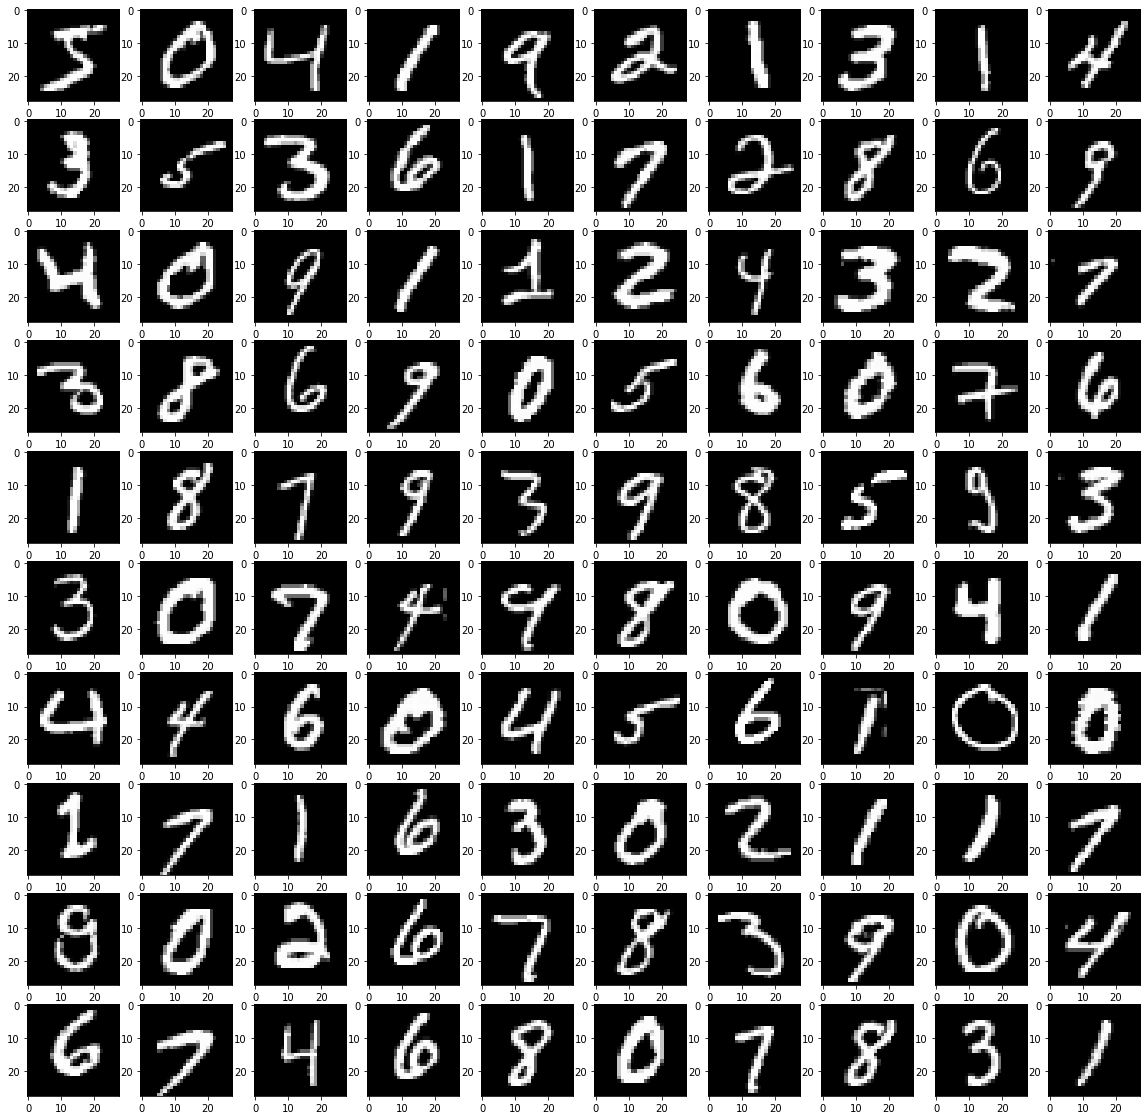

In [4]:
print("Examples of X")
def draw_digit(data, row, col, n):
    size = 28
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()

show_size = 10
total = 0
plt.figure(figsize=(20,20))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(X_train[total], show_size, show_size, total+1)
        total += 1
plt.show()

In [5]:
print("Examples of y_train")
print("Labels of the first 5 examples.")
y_train[:5]

Examples of y_train
Labels of the first 5 examples.


array([5, 0, 4, 1, 9], dtype=uint8)

### Data preperation

- Reshape arrays
- Normalization
- One-hot on the target

**Reshape arrays**

I will use gray scale instead of RGB because of the data which is digits that do not matter colors.

In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

**Normalization**

In order to make training efficiant, meaning that Gradient Descent converges faster and reducing training time, I scale all the input values of arrays.

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

**One-hot on the target**

What Keras expects for the target format is one-hot.

In [8]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

**Data shape**

In [9]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)
Shape of X_test: (10000, 28, 28, 1)
Shape of y_test: (10000, 10)


### Build a simple CNN model

- Why I use CNN model?
- Why build a simple model at first?
- Model code

**Why I use CNN model?**

CNN is widly used and is a technology in Neural Networks for image recognition, image classification, etc.
Here is the basic archtecture of a CNN model.

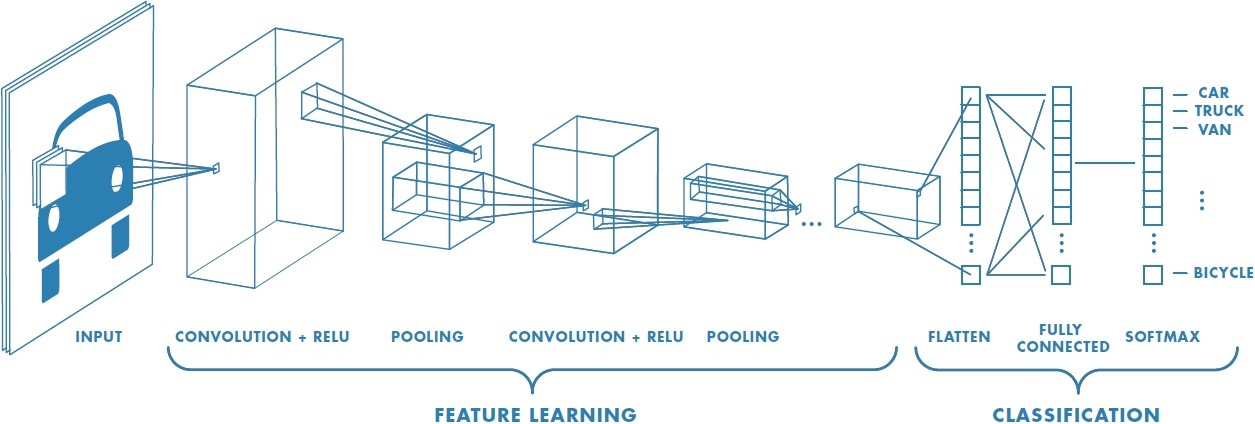

**Why build a simple model at first?**

- Save time and computationaly cheap
- Make sure if everything makes sense

Almost always I start building from a simple model in order to get something that works. What I mean by that is that a model gives me something that I am expecting.<br>
In this case, what comes into a model is arrays of pixels of hand-written digits, and what is supposed to come out from a model is the probability of being classified out of 10 categories.<br>
Calculate metrics which are recall, precision, and f1-score in this case and will make sure each metrics make sense.<br>
For example, f1-score should be in a range between 0 and 1, which the more close to 1 is the better. But if I get 0.2 let's say, it would mean that there may be something wrong in the process of training model or data processing.<br>

Then iteratively build more complicated models, which means adding more nuerons in each layers, adding more layers, etc.

**Model code**

As I mentioned above, I create a simple model so there are just a few conv and dense layers and is no regularization and use default hyperparameters.

In [10]:
def get_model():
    """
    Build a cnn model.
    
    Return
    ---------
    model: Keras model
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [11]:
model = get_model()
model.summary()

W1005 08:32:31.521309 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1005 08:32:31.525424 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1005 08:32:31.592686 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1005 08:32:31.668715 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. P

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
____________________________________________

**Define metrics functions**

Found implementation of recall, recall, anf f1 score metrics.<br>
https://github.com/shiita0903/Keras_metrics/blob/master/mnist.py

In [12]:
# Reference: https://qiita.com/shiita0903/items/838d50598cc28766f84e
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])


def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2),
                  K.floatx())


def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())


def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) \
                / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) \
                / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) \
               / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) \
               / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def generate_metrics():
    metrics = ["accuracy"]

    func_list = [class_accuracy, class_precision, class_recall, class_f_measure]
    name_list = ["acc", "precision", "recall", "f_measure"]
    for i in range(10):
        for func, name in zip(func_list, name_list):
            func = partial(func, i)
            func.__name__ = "{}-{}".format(name, i)
            metrics.append(func)

    metrics.append(average_accuracy)
    metrics.append(macro_precision)
    metrics.append(macro_recall)
    metrics.append(macro_f_measure)

    return metrics

### Train a model and model evaluation

The total number of samples that I can use for training is 60000.<br>
I need data for training as much as I can but the amount of data for validation is also important.<br>
The reason why I chose 15% of X for validation set is that tried to briefly close to the amount of test set.

In [13]:
adam = Adam(lr=0.001, beta_1=0.9,
                      beta_2=0.999,
                      epsilon=None,
                      decay=0.0,
                      amsgrad=False)
model.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=generate_metrics())

# Callbacks
es = EarlyStopping(monitor='val_acc',
                             patience=3,
                             verbose=1,
                             mode='auto')
ch = ModelCheckpoint(str(best_model_path),
                                   monitor='val_acc',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 mode='auto',
                                                 min_lr=0.00005)

tb = TensorBoard(log_dir="../tensorboard/20191005_ver1/")
callbacks = [es, ch, reduce_lr, tb]

history = model.fit(X_train, y_train,
                            validation_split=0.15,
                            epochs=10,
                            batch_size=32,
                            verbose=1,
                            callbacks=callbacks)

W1005 08:32:31.808951 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1005 08:32:31.820410 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.

W1005 08:32:36.245445 4645144000 deprecation.py:323] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1005 08:32:36.334184 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7

Train on 51000 samples, validate on 9000 samples


W1005 08:32:37.431130 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1005 08:32:37.432064 4645144000 deprecation_wrapper.py:119] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
51000/51000 [==============================] - 190s 4ms/step - loss: 0.1200 - acc: 0.9626 - acc-0: 0.9955 - precision-0: 0.9490 - recall-0: 0.9515 - f_measure-0: 0.9465 - acc-1: 0.9951 - precision-1: 0.9499 - recall-1: 0.9553 - f_measure-1: 0.9493 - acc-2: 0.9927 - precision-2: 0.9323 - recall-2: 0.9264 - f_measure-2: 0.9232 - acc-3: 0.9918 - precision-3: 0.9240 - recall-3: 0.9190 - f_measure-3: 0.9160 - acc-4: 0.9927 - precision-4: 0.9255 - recall-4: 0.9238 - f_measure-4: 0.9187 - acc-5: 0.9925 - precision-5: 0.9088 - recall-5: 0.9047 - f_measure-5: 0.9002 - acc-6: 0.9935 - precision-6: 0.9390 - recall-6: 0.9455 - f_measure-6: 0.9374 - acc-7: 0.9918 - precision-7: 0.9325 - recall-7: 0.9329 - f_measure-7: 0.9270 - acc-8: 0.9900 - precision-8: 0.9115 - recall-8: 0.9126 - f_measure-8: 0.9048 - acc-9: 0.9896 - precision-9: 0.9079 - recall-9: 0.9116 - f_measure-9: 0.9025 - average_accuracy: 0.9925 - macro_precision: 0.9280 - macro_recall: 0.9283 - macro_f_measure: 0.9281 - val_l


Epoch 00004: val_acc improved from 0.98867 to 0.98933, saving model to ../models/best_model_20191004.h5
Epoch 5/10
51000/51000 [==============================] - 182s 4ms/step - loss: 0.0096 - acc: 0.9968 - acc-0: 0.9996 - precision-0: 0.9596 - recall-0: 0.9591 - f_measure-0: 0.9590 - acc-1: 0.9995 - precision-1: 0.9731 - recall-1: 0.9728 - f_measure-1: 0.9725 - acc-2: 0.9994 - precision-2: 0.9600 - recall-2: 0.9600 - f_measure-2: 0.9597 - acc-3: 0.9992 - precision-3: 0.9632 - recall-3: 0.9629 - f_measure-3: 0.9625 - acc-4: 0.9994 - precision-4: 0.9605 - recall-4: 0.9613 - f_measure-4: 0.9604 - acc-5: 0.9995 - precision-5: 0.9545 - recall-5: 0.9544 - f_measure-5: 0.9541 - acc-6: 0.9995 - precision-6: 0.9652 - recall-6: 0.9651 - f_measure-6: 0.9647 - acc-7: 0.9993 - precision-7: 0.9687 - recall-7: 0.9695 - f_measure-7: 0.9686 - acc-8: 0.9992 - precision-8: 0.9564 - recall-8: 0.9572 - f_measure-8: 0.9560 - acc-9: 0.9991 - precision-9: 0.9634 - recall-9: 0.9623 - f_measure-9: 0.9622 - av


Epoch 00008: val_acc did not improve from 0.98978

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/10
51000/51000 [==============================] - 175s 3ms/step - loss: 0.0017 - acc: 0.9995 - acc-0: 1.0000 - precision-0: 0.9674 - recall-0: 0.9674 - f_measure-0: 0.9674 - acc-1: 0.9999 - precision-1: 0.9814 - recall-1: 0.9817 - f_measure-1: 0.9815 - acc-2: 1.0000 - precision-2: 0.9649 - recall-2: 0.9647 - f_measure-2: 0.9648 - acc-3: 0.9999 - precision-3: 0.9700 - recall-3: 0.9710 - f_measure-3: 0.9703 - acc-4: 0.9999 - precision-4: 0.9590 - recall-4: 0.9587 - f_measure-4: 0.9588 - acc-5: 0.9999 - precision-5: 0.9500 - recall-5: 0.9496 - f_measure-5: 0.9497 - acc-6: 0.9998 - precision-6: 0.9628 - recall-6: 0.9635 - f_measure-6: 0.9631 - acc-7: 0.9999 - precision-7: 0.9709 - recall-7: 0.9710 - f_measure-7: 0.9709 - acc-8: 0.9998 - precision-8: 0.9625 - recall-8: 0.9617 - f_measure-8: 0.9619 - acc-9: 0.9999 - precision-9: 0.9699 - recall-9: 0.969

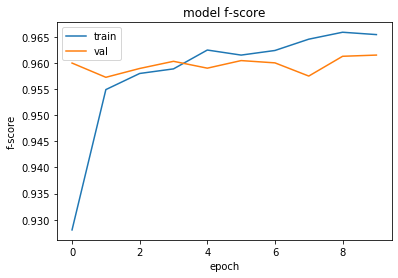

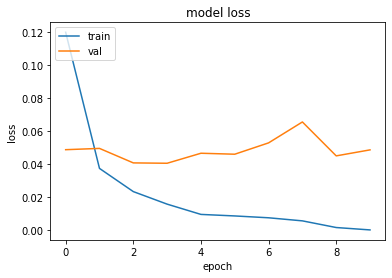

In [14]:
# summarize history for accuracy
plt.plot(history.history['macro_f_measure'])
plt.plot(history.history['val_macro_f_measure'])
plt.title('model f-score')
plt.ylabel('f-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Result of the training**

The validation accuracy acheaved nearly 99%, but there is a problem which is overfitting as know as high variance that we almost always should avoid.<br>
How can I tackle this problem?
- **Use more data**. I could do data augmentation.
- **Regularlization**. For example, dropout and L2 regularization.
- **Make the model simpler**. What I mean by that in this case is that, for example, in neural nets, decrease the number of layers, the number of neurons in each layer, etc.

Here I will use dropout because it is easiest approach for me.

In [15]:
def get_model_with_dropout():
    """
    Build a cnn model with dropout.
    
    Return
    ---------
    model: Keras model
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    return model

In [16]:
model_ver2 = get_model_with_dropout()
model_ver2.summary()

W1005 09:02:21.132694 4645144000 deprecation.py:506] From /Users/koheisuzuki/anaconda3/envs/ml37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [17]:
adam = Adam(lr=0.001, beta_1=0.9,
                      beta_2=0.999,
                      epsilon=None,
                      decay=0.0,
                      amsgrad=False)
model_ver2.compile(loss='categorical_crossentropy',
                              optimizer=adam,
                              metrics=generate_metrics())

# Callbacks
es = EarlyStopping(monitor='val_acc',
                             patience=3,
                             verbose=1,
                             mode='auto')
ch = ModelCheckpoint(str(best_model_path_ver2),
                                  monitor='val_acc',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='auto', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                                                 factor=0.1,
                                                 patience=2,
                                                 verbose=1,
                                                 mode='auto',
                                                 min_lr=0.00005)

tb = TensorBoard(log_dir="../tensorboard/20191005_ver2/")
callbacks = [es, ch, reduce_lr, tb]

history_ver2 = model_ver2.fit(X_train, y_train,
                                            validation_split=0.15,
                                            epochs=10,
                                            batch_size=32,
                                            verbose=1,
                                            callbacks=callbacks)

Train on 51000 samples, validate on 9000 samples
Epoch 1/10
51000/51000 [==============================] - 235s 5ms/step - loss: 0.1749 - acc: 0.9464 - acc-0: 0.9932 - precision-0: 0.9296 - recall-0: 0.9366 - f_measure-0: 0.9281 - acc-1: 0.9936 - precision-1: 0.9533 - recall-1: 0.9589 - f_measure-1: 0.9520 - acc-2: 0.9880 - precision-2: 0.9042 - recall-2: 0.9055 - f_measure-2: 0.8966 - acc-3: 0.9879 - precision-3: 0.9111 - recall-3: 0.9039 - f_measure-3: 0.8989 - acc-4: 0.9901 - precision-4: 0.9126 - recall-4: 0.9070 - f_measure-4: 0.9021 - acc-5: 0.9884 - precision-5: 0.8880 - recall-5: 0.8845 - f_measure-5: 0.8772 - acc-6: 0.9920 - precision-6: 0.9342 - recall-6: 0.9408 - f_measure-6: 0.9316 - acc-7: 0.9898 - precision-7: 0.9211 - recall-7: 0.9200 - f_measure-7: 0.9132 - acc-8: 0.9841 - precision-8: 0.8867 - recall-8: 0.8820 - f_measure-8: 0.8737 - acc-9: 0.9856 - precision-9: 0.9012 - recall-9: 0.9036 - f_measure-9: 0.8921 - average_accuracy: 0.9893 - macro_precision: 0.9142 - macro


Epoch 00004: val_acc improved from 0.98722 to 0.98922, saving model to ../models/best_model_path_ver2.h5
Epoch 5/10
51000/51000 [==============================] - 243s 5ms/step - loss: 0.0598 - acc: 0.9841 - acc-0: 0.9981 - precision-0: 0.9596 - recall-0: 0.9584 - f_measure-0: 0.9575 - acc-1: 0.9981 - precision-1: 0.9742 - recall-1: 0.9757 - f_measure-1: 0.9738 - acc-2: 0.9968 - precision-2: 0.9482 - recall-2: 0.9463 - f_measure-2: 0.9446 - acc-3: 0.9963 - precision-3: 0.9538 - recall-3: 0.9532 - f_measure-3: 0.9508 - acc-4: 0.9968 - precision-4: 0.9506 - recall-4: 0.9496 - f_measure-4: 0.9475 - acc-5: 0.9966 - precision-5: 0.9340 - recall-5: 0.9338 - f_measure-5: 0.9311 - acc-6: 0.9979 - precision-6: 0.9549 - recall-6: 0.9571 - f_measure-6: 0.9541 - acc-7: 0.9968 - precision-7: 0.9555 - recall-7: 0.9559 - f_measure-7: 0.9534 - acc-8: 0.9954 - precision-8: 0.9460 - recall-8: 0.9484 - f_measure-8: 0.9436 - acc-9: 0.9953 - precision-9: 0.9433 - recall-9: 0.9429 - f_measure-9: 0.9392 - a


Epoch 00008: val_acc did not improve from 0.99089
Epoch 9/10
51000/51000 [==============================] - 240s 5ms/step - loss: 0.0171 - acc: 0.9948 - acc-0: 0.9995 - precision-0: 0.9575 - recall-0: 0.9581 - f_measure-0: 0.9574 - acc-1: 0.9992 - precision-1: 0.9787 - recall-1: 0.9779 - f_measure-1: 0.9779 - acc-2: 0.9988 - precision-2: 0.9619 - recall-2: 0.9621 - f_measure-2: 0.9608 - acc-3: 0.9990 - precision-3: 0.9552 - recall-3: 0.9551 - f_measure-3: 0.9543 - acc-4: 0.9991 - precision-4: 0.9640 - recall-4: 0.9640 - f_measure-4: 0.9632 - acc-5: 0.9990 - precision-5: 0.9475 - recall-5: 0.9469 - f_measure-5: 0.9464 - acc-6: 0.9991 - precision-6: 0.9636 - recall-6: 0.9647 - f_measure-6: 0.9634 - acc-7: 0.9986 - precision-7: 0.9563 - recall-7: 0.9561 - f_measure-7: 0.9552 - acc-8: 0.9988 - precision-8: 0.9615 - recall-8: 0.9622 - f_measure-8: 0.9610 - acc-9: 0.9985 - precision-9: 0.9582 - recall-9: 0.9588 - f_measure-9: 0.9571 - average_accuracy: 0.9990 - macro_precision: 0.9604 - mac

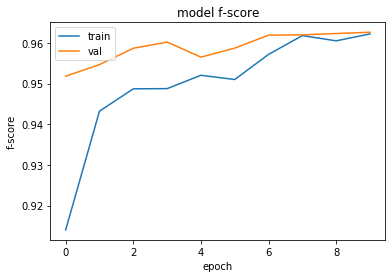

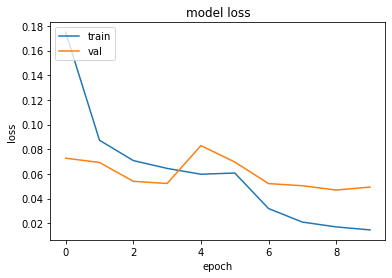

In [18]:
# summarize history for accuracy
plt.plot(history_ver2.history['macro_f_measure'])
plt.plot(history_ver2.history['val_macro_f_measure'])
plt.title('model f-score')
plt.ylabel('f-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_ver2.history['loss'])
plt.plot(history_ver2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model still overfit the training data, but the curve and acc are better than before.

### How to improve the model?

Let's review what I have got so far.<br>
- Data processing<br>
- Built models<br>
- Trained them with and without dropout<br>

There is one more thing I need to do which is hyperparameter tuning.<br>
I am going to use Hyperas which is a frame work for Hyperparameter search of Keras model.<br>
Github: https://github.com/maxpumperla/hyperas

In [ ]:
def prepare_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return X_train, y_train, X_test, y_test

In [ ]:
def create_model(X_train, X_test, y_train, y_test):
    # Define save model path
    best_model_path_hyperas = Path("../models/hyperas_model_20191004.h5")
    best_model_path_hyperas = Path(str(best_model_path_hyperas))

    # Define model's archtecture
    model = Sequential()
    model.add(Conv2D({{choice([32, 64, 128, 256])}},
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 input_shape=(28, 28, 1)))
    model.add(Conv2D({{choice([32, 64, 128, 256])}},
                                 kernel_size=(3, 3),
                                 activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Flatten())
    model.add(Dense({{choice([32, 64, 128])}},
                               activation='relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(10, activation='softmax'))

    adam = Adam(lr=0.001,
                           beta_1=0.9,
                           beta_2=0.999,
                           epsilon=None,
                           decay=0.0,
                           amsgrad=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam, metrics=generate_metrics())

    # Callbacks
    es = EarlyStopping(monitor='macro_f_measure',
                                 patience=3,
                                 verbose=1,
                                 mode='auto')
    ch = ModelCheckpoint(str(best_model_path_hyperas),
                                       monitor='macro_f_measure',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto', period=1)
    reduce_lr = ReduceLROnPlateau(monitor='macro_f_measure',
                                                     factor=0.1,
                                                     patience=2,
                                                     verbose=1,
                                                     mode='auto',
                                                     min_lr=0.00005)
    
    tb = TensorBoard(log_dir="../tensorboard/20191004_hyperas/")
    callbacks = [es, ch, reduce_lr, tb]

    # Train model
    model.fit(X_train, y_train,
                  epochs=10,
                  batch_size={{choice([4, 8, 16, 32])}},
                  validation_split=0.15,
                  callbacks=callbacks)

    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
    # The format of Hyperas
    return {'loss': -val_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
print("Starting hyperparameter search")
best_run, best_model = optim.minimize(model=create_model,
                                                           data=prepare_data,
                                                           algo=tpe.suggest,
                                                           max_evals=40, # The number of combinations of hyperharameters I try
                                                           trials=Trials(),
                                                           notebook_name="K1")
print("Finished hyperparameter search")
print("=============================================================")
print("The best run: \n")
print(best_run)
print("=============================================================")
_, _, X_test, y_test = prepare_data()
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test loss: {}".format(test_loss))
print("Test acc: {}".format(test_acc))